In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from PIL import Image
import matplotlib as mpl

In [2]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})


In [10]:
# repo root
p = Path.cwd().resolve()
for _ in range(10):
    if (p / "data").is_dir() and (p / "scripts").is_dir():
        REPO_ROOT = p
        break
    if p == p.parent:
        raise RuntimeError("Could not find repo root")
    p = p.parent

OEM8_HEX = {
    1: "#800000", 2: "#00FF24", 3: "#949494", 4: "#FFFFFF",
    5: "#226126", 6: "#0045FF", 7: "#4BB549", 8: "#DE1F07",
}
OEM8_NAMES = {
    1: "Bareland", 2: "Rangeland", 3: "Developed space", 4: "Road",
    5: "Tree", 6: "Water", 7: "Agriculture land", 8: "Building",
}

COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}
CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "Semi-Natural Grassland",
}


In [11]:
from matplotlib.patches import Rectangle

def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)

def read_rgb_and_mpp(image_tif, band_order=(1,2,3)):
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read(list(band_order)).astype(np.float32), (1,2,0))
        rgb[~np.isfinite(rgb)] = np.nan

        px = abs(float(src.transform.a))
        if src.crs is not None and src.crs.is_projected:
            mpp_x = px
        else:
            cy = (src.bounds.top + src.bounds.bottom) / 2.0
            mpp_x = px * 111320.0 * np.cos(np.deg2rad(cy))

    return rgb_percentile_uint8(rgb), mpp_x

def read_mask_tif(mask_tif):
    with rasterio.open(mask_tif) as src:
        return src.read(1)

def read_mask_any(mask_path):
    mask_path = Path(mask_path)
    if mask_path.suffix.lower() in [".tif", ".tiff"]:
        return read_mask_tif(mask_path)
    if mask_path.suffix.lower() == ".png":
        arr = np.array(Image.open(mask_path))
        if arr.ndim == 3:
            arr = arr[..., 0]
        return arr
    raise ValueError(f"Unsupported mask format: {mask_path}")

def add_scale_bar_pixels(ax, img_shape, meters_per_pixel, length_m=100,
                         pad_px=14, bar_height_px=6):
    h, w = img_shape[:2]
    bar_len_px = int(round(length_m / meters_per_pixel))
    bar_len_px = min(bar_len_px, w - 2 * pad_px)
    if bar_len_px < 3:
        return

    x0 = pad_px
    y0 = h - pad_px - bar_height_px
    ax.add_patch(Rectangle((x0, y0), bar_len_px, bar_height_px,
                           facecolor="black", edgecolor="black"))
    ax.text(x0 + bar_len_px/2, y0 - 5, f"{length_m} m",
            ha="center", va="bottom", fontsize=10,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1))

def add_north_arrow_pixels(ax, img_shape, pad_px=18, size_px=36):
    h, w = img_shape[:2]
    x = w - pad_px
    y = h - pad_px
    ax.annotate("N", xy=(x, y - size_px), xytext=(x, y),
                ha="center", va="center", fontsize=10, fontweight="bold",
                arrowprops=dict(arrowstyle="-|>", linewidth=1.0),
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1))


In [12]:
from matplotlib.colors import ListedColormap, BoundaryNorm, to_rgb
from matplotlib.patches import Patch

# OEM 8-class colours + names
OEM8_HEX = {
    1: "#800000", 2: "#00FF24", 3: "#949494", 4: "#FFFFFF",
    5: "#226126", 6: "#0045FF", 7: "#4BB549", 8: "#DE1F07",
}

OEM8_NAMES = {
    1: "Bareland",
    2: "Rangeland",
    3: "Developed space",
    4: "Road",
    5: "Tree",
    6: "Water",
    7: "Agriculture land",
    8: "Building",
}

# Biodiversity 6-class palette
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}

CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "Semi-Natural Grassland",
}


In [13]:
from matplotlib.colors import ListedColormap, BoundaryNorm, to_rgb
from matplotlib.patches import Patch
from pathlib import Path

def plot_fig4_taxonomy(rgb_tif, mask8_path, mask6_path, out_pdf, scale_m=100):
    rgb8, mpp = read_rgb_and_mpp(rgb_tif)
    mask8 = read_mask_any(mask8_path)
    mask6 = read_mask_any(mask6_path)

    print("Unique OEM IDs:", np.unique(mask8))
    print("Unique mapped IDs:", np.unique(mask6))

    cmap8 = ListedColormap([to_rgb(OEM8_HEX[i]) for i in range(1, 9)])
    norm8 = BoundaryNorm(np.arange(0.5, 9.5, 1), cmap8.N)

    biodiv_colors = np.array([COLOR_MAP[i] for i in range(6)]) / 255.0
    cmap6 = ListedColormap(biodiv_colors)
    norm6 = BoundaryNorm(np.arange(-0.5, 6.5), cmap6.N)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    fig.subplots_adjust(bottom=0.36, wspace=0.02)

    axes[0].imshow(rgb8)
    axes[0].set_axis_off()
    axes[0].text(0.5, 1.02, "(a)", transform=axes[0].transAxes,
                 ha="center", va="bottom", fontsize=12, fontweight="bold")
    add_scale_bar_pixels(axes[0], rgb8.shape, mpp, length_m=scale_m)
    add_north_arrow_pixels(axes[0], rgb8.shape)

    axes[1].imshow(mask8, cmap=cmap8, norm=norm8, interpolation="nearest", resample=False)
    axes[1].set_axis_off()
    axes[1].text(0.5, 1.02, "(b)", transform=axes[1].transAxes,
                 ha="center", va="bottom", fontsize=12, fontweight="bold")

    axes[2].imshow(mask6, cmap=cmap6, norm=norm6, interpolation="nearest", resample=False)
    axes[2].set_axis_off()
    axes[2].text(0.5, 1.02, "(c)", transform=axes[2].transAxes,
                 ha="center", va="bottom", fontsize=12, fontweight="bold")

    oem_handles = [
        Patch(facecolor=to_rgb(OEM8_HEX[i]),
              edgecolor="black" if i == 4 else "none",
              label=OEM8_NAMES[i])
        for i in range(1, 9)
    ]
    axes[1].legend(handles=oem_handles, loc="upper center",
                   bbox_to_anchor=(0.5, 0), ncol=2,
                   frameon=False, fontsize=9,
                   handlelength=1.2, handleheight=1.0,
                   columnspacing=1.2, labelspacing=0.6)

    biodiv_handles = [
        Patch(facecolor=np.array(COLOR_MAP[i]) / 255.0,
              edgecolor="none",
              label=CLASS_NAMES[i])
        for i in [1,2,3,4,5]
    ]
    axes[2].legend(handles=biodiv_handles, loc="upper center",
                   bbox_to_anchor=(0.6, 0), ncol=1,
                   frameon=False, fontsize=9,
                   handlelength=1.2, handleheight=1.0,
                   columnspacing=1.2, labelspacing=0.6)

    out_pdf = Path(out_pdf)
    out_pdf.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_pdf, bbox_inches="tight")
    plt.show()

    print("Saved:", out_pdf)


Unique OEM IDs: [2 3 4 5 7 8]
Unique mapped IDs: [1 2 3 4]


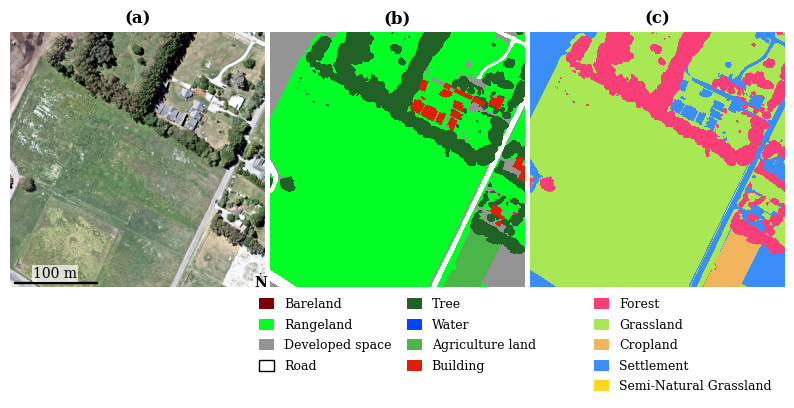

Saved: /home/lainey/Documents/Github/ClassImbalance/outputs/figures/fig4_taxonomy_mapping.pdf


In [21]:
from pathlib import Path

# relabelled basename (your dataprep naming)
tile_relab = "oem_christchurch_christchurch_36"

# raw basename (OEM original naming)
tile_raw = "christchurch_36"

rgb_tif = REPO_ROOT / f"data/openearthmap_relabelled/images/{tile_relab}.tif"
mask6_png = REPO_ROOT / f"data/openearthmap_relabelled/masks/{tile_relab}.png"

mask8_tif = REPO_ROOT / (
    f"data/openearthmap_raw/OpenEarthMap/OpenEarthMap_wo_xBD/christchurch/labels/{tile_raw}.tif"
)

assert rgb_tif.exists(), rgb_tif
assert mask6_png.exists(), mask6_png
assert mask8_tif.exists(), mask8_tif

out_pdf = REPO_ROOT / "outputs/figures/fig4_taxonomy_mapping.pdf"

plot_fig4_taxonomy(
    rgb_tif=rgb_tif,
    mask8_path=mask8_tif,
    mask6_path=mask6_png,
    out_pdf=out_pdf,
    scale_m=100,
)


In [22]:
from pathlib import Path
import numpy as np

def urban_fraction(mask8: np.ndarray) -> float:
    # OEM IDs: 3 developed, 4 road, 8 building
    urban = np.isin(mask8, [3, 4, 8]).sum()
    return urban / mask8.size

mask_path = REPO_ROOT / "data/openearthmap_raw/OpenEarthMap/OpenEarthMap_wo_xBD/christchurch/labels/christchurch_36.tif"
m = read_mask_any(mask_path)
print("urban fraction:", urban_fraction(m))
print("unique ids:", np.unique(m))


urban fraction: 0.12159061431884766
unique ids: [2 3 4 5 7 8]
